In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
import random


In [2]:
#read all the data:
items = pd.read_csv("dressipi_recsys2022/item_features.csv")
candidate = pd.read_csv("dressipi_recsys2022/candidate_items.csv")
purchase =  pd.read_csv("dressipi_recsys2022/train_purchases.csv")
sessions =  pd.read_csv("dressipi_recsys2022/train_sessions.csv")
sessions_test = pd.read_csv("dressipi_recsys2022/test_final_sessions.csv")
leaderboard = pd.read_csv("dressipi_recsys2022/test_leaderboard_sessions.csv")

In [3]:
#set the date column to a date format
purchase['date'] = pd.to_datetime(purchase['date'])
#list of unique items:
items_unique = sessions.item_id.unique()

In [4]:
max_day = purchase['date'].max() #max date 31/05/2021 
min_day = max_day -datetime.timedelta(31)
cond = purchase['date'] >= min_day
new_purchases = purchase[cond]

In [5]:
sessions_item_dict = {}
item_sessions_dict = {}
for i,x in enumerate(zip(sessions['session_id'], sessions['item_id'])):
    session, item = x
    if session not in sessions_item_dict:
        sessions_item_dict[session] = {}
    
    if item not in item_sessions_dict:
        item_sessions_dict[item] = {}
        
    if item not in sessions_item_dict[session]:
        sessions_item_dict[session][item] = 0
    
    if session not in item_sessions_dict[item]:
        item_sessions_dict[item][session] = 0
        
    sessions_item_dict[session][item] += 1
    item_sessions_dict[item][session] += 1

In [6]:
def generate_positive(max_num = 25):
    '''
    Generates Samples of Products seen in the same Session
    with a maximum amount of max_num items per item
    '''
    positive = []
    positive_dict = {}
    for item in tqdm(item_sessions_dict):
        cont = 0
        for session in item_sessions_dict[item]:
            for elem in sessions_item_dict[session]:
                positive.append([item,elem])
                cont += 1
                if item not in positive_dict:
                    positive_dict[item] = []
                positive_dict[item].append(elem)
                if(cont == max_num): break
            if(cont == max_num): break
                
    return positive, positive_dict

positive_sample,positive_dict = generate_positive() #generates data of positive samples    

100%|██████████| 23496/23496 [00:01<00:00, 16897.20it/s]


In [7]:
def generate_negative(max_num = 50):
    '''Generates Samples of Products not seen in the same Session
    with a maximum amount of max_num items per item'''
    negative = []
    for item in tqdm(items_unique):
        for i in range(max_num):
            negative_sample = random.choice(items_unique)
            if negative_sample not in positive_dict[item] and negative_sample != item:
                negative.append([item,negative_sample])
    return negative   

negative_sample = generate_negative()

100%|██████████| 23496/23496 [00:11<00:00, 2115.41it/s]


In [9]:
def get_item_features():
    items_features = {}
    new_item = 2
    features = []
    for i in tqdm(range(len(items))):
        if(items.iloc[i].item_id == new_item):
            features.append(items.iloc[i].feature_category_id)
            features.append(items.iloc[i].feature_value_id)
        else:
            items_features[new_item] = features
            new_item = items.iloc[i].item_id
            features = []
            features.append(items.iloc[i].feature_category_id)
            features.append(items.iloc[i].feature_value_id)
    return items_features
item_features = get_item_features()

100%|██████████| 471751/471751 [02:02<00:00, 3839.40it/s]


In [11]:
#####Let's Proceed now to generate the actual Siamesian Network############
#https://keras.io/examples/vision/siamese_contrastive/

In [14]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [84]:
def generate_dataset():
    full_dataset = np.vstack((positive_sample,negative_sample))
    full_dataset = pd.DataFrame(full_dataset)
    full_dataset['label'] = 0
    full_dataset['label'].iloc[0:len(positive_sample)-1] = 1
    train = full_dataset.iloc[:,0:2]
    test = full_dataset.iloc[:,2:3]    
    X_train,X_val,y_train,y_val = train_test_split(train,test,test_size = 0.2,random_state = 42,shuffle = True)
    return X_train,X_val,y_train,y_val  

In [94]:
X_train,X_val,y_train,y_val = generate_dataset()

We will define it now with Euclidean Distance and after we will see how to more accurately fix it:

# Siamese:

In [152]:
epochs = 5
batch_size = 256
margin = 1  # Margin for constrastive loss.

In [103]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [104]:
###Now let's define the Siamese Network:

In [147]:
input = layers.Input((1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((1))
input_2 = layers.Input((1))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])

normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)

output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [148]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [149]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_10 (Functional)          (None, 16)           2740        ['input_18[0][0]',               
                                                                  'input_19[0][0]']               
                                                                                                  
 lambda_5 (Lambda)              (None, 1)            0           ['model_10[0][0]',        

In [155]:
history = siamese.fit(
    [np.array(X_train.astype("float32"))[:,0], np.array(X_train.astype("float32"))[:,1]],
    np.array(y_train.astype("float32")),
    validation_data=([np.array(X_val.astype("float32"))[:,0], np.array(X_val.astype("float32"))[:,1]], np.array(y_val.astype("float32"))),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/5
5319/5319 [==============================] - 15s 3ms/step - loss: 0.2106 - accuracy: 0.6889 - val_loss: 0.2083 - val_accuracy: 0.6912
Epoch 2/5
5319/5319 [==============================] - 16s 3ms/step - loss: 0.2105 - accuracy: 0.6888 - val_loss: 0.2083 - val_accuracy: 0.7223
Epoch 3/5
5319/5319 [==============================] - 15s 3ms/step - loss: 0.2106 - accuracy: 0.6888 - val_loss: 0.2080 - val_accuracy: 0.7242
Epoch 4/5
5319/5319 [==============================] - 15s 3ms/step - loss: 0.2105 - accuracy: 0.6888 - val_loss: 0.2081 - val_accuracy: 0.7249
Epoch 5/5
5319/5319 [==============================] - 16s 3ms/step - loss: 0.2105 - accuracy: 0.6887 - val_loss: 0.2081 - val_accuracy: 0.6912


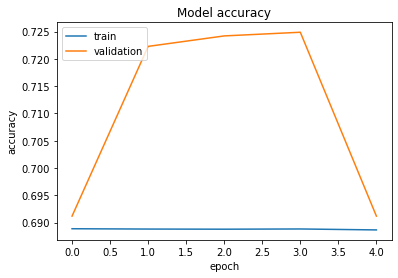

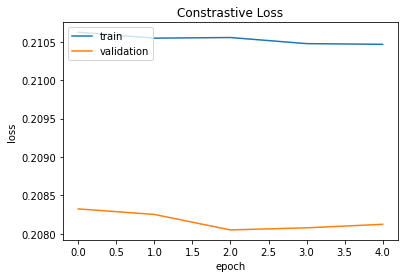

In [156]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")